In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-06-06 01:48:30.201091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-06 01:48:30.201120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = data

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state = 102,shuffle = True)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
    training = train_data
    test = test_data

    training = training[["Peruntukan","Jarak_pusat_kota2","Visibilitas","Bangunan","Luas"]]
    test = test[["Peruntukan","Jarak_pusat_kota2","Visibilitas","Bangunan","Luas"]]

    print(training)
    print(test)
    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=1):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak_pusat_kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs,log_dir):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    tf.summary.histogram("Dense Layer", x)

    # Tentukan direktori untuk menyimpan log
    # log_dir = "logs"

    # Buat objek FileWriter
    
    writer = tf.summary.create_file_writer(log_dir)

    # Callback untuk menyimpan log pada setiap epoch
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    return model, tensorboard_callback, writer
    

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds,tb_callbacks):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=[callbacks,tb_callbacks])

    
    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks, log_dir):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    
    #set the model
    model_engine, tensorboard_callback, writer = model(encoded,inputs,log_dir)
    writer.close()
    

    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds,tensorboard_callback)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)
    
    

In [12]:
def confussion_matrix(best_model, val_ds, test_data):
    from sklearn.metrics import confusion_matrix   
    model = best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    # Test labels
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    val_accuracy = model.history['val_accuracy']
    train_accuracy = model.history['accuracy']

    # Find the index where validation accuracy is highest
    max_val_accuracy_index = np.argmax(val_accuracy)

    # Find the index of the closest training accuracy to the maximum validation accuracy
    closest_train_accuracy_index = np.argmin([abs(i - max_val_accuracy_index) for i in range(len(train_accuracy))])

    print('Best validation accuracy:', val_accuracy[max_val_accuracy_index])
    print('Closest training accuracy to the maximum validation accuracy:', train_accuracy[closest_train_accuracy_index])




    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
 
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Accuracy:", total_accuracy)
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    
    print("TP for each label", true_positives)
    print("Total data for each label",  np.sum(confusion_matrix, axis=1))
    print("FP for each label", np.sum(confusion_matrix, axis=0) - true_positives)
    print("FN for each label", np.sum(confusion_matrix, axis=1) - true_positives)
    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)

    

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5
log_dir1 = "./log50"

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4
log_dir2 = "./log40"

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3
log_dir3 = "./log30"

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2
log_dir4 = "./log20"

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1
log_dir5 = "./log10"

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
57       Pasar        1031.829535   Strategis   Sedang   2252
43       Pasar        1676.146577   Strategis   Sedang   3840
29       Pasar        1730.459693   Strategis   Sedang   5784
32       Pasar        2406.214384   Strategis   Sedang   5200
41       Pasar        1839.107811   Strategis   Sedang   3987
11       Pasar         765.887686   Strategis    Bagus  15710
69       Pasar        3310.271455   Strategis   Sedang   1490
64       Pasar        1703.886238   Strategis   Sedang   1735
0        Pasar        2592.305034   Strategis   Sedang  87580
5    Perumahan        2535.506573      Sedang   Sedang  27024
10   Perumahan        4519.160513      Kurang   Sedang  16590
1    Perumahan        2289.806804      Sedang   Sedang  87580
31       Sawah        5402.735138      Kurang   Kosong   5700
22       Sawah        2766.267155      Kurang   Kosong   6635
23       Sawah        4216.298352      Kurang   Kosong   6390
25      

Epoch 13/150
49/49 [==============================] - 0s 4ms/step - loss: 1.1260 - accuracy: 0.5714 - val_loss: 1.0913 - val_accuracy: 0.7407
Epoch 14/150
49/49 [==============================] - 0s 4ms/step - loss: 1.1136 - accuracy: 0.5918 - val_loss: 1.0656 - val_accuracy: 0.7593
Epoch 15/150
49/49 [==============================] - 0s 4ms/step - loss: 1.1347 - accuracy: 0.5102 - val_loss: 1.0409 - val_accuracy: 0.7593
Epoch 16/150
49/49 [==============================] - 0s 4ms/step - loss: 1.0282 - accuracy: 0.5714 - val_loss: 1.0167 - val_accuracy: 0.7593
Epoch 17/150
49/49 [==============================] - 0s 4ms/step - loss: 1.0764 - accuracy: 0.5714 - val_loss: 0.9953 - val_accuracy: 0.7778
Epoch 18/150
49/49 [==============================] - 0s 4ms/step - loss: 1.0911 - accuracy: 0.4490 - val_loss: 0.9716 - val_accuracy: 0.7778
Epoch 19/150
49/49 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5918 - val_loss: 0.9516 - val_accuracy: 0.7963
Epoch 

49/49 [==============================] - 0s 4ms/step - loss: 0.4625 - accuracy: 0.8571 - val_loss: 0.5721 - val_accuracy: 0.8333
Epoch 71/150
49/49 [==============================] - 0s 4ms/step - loss: 0.5382 - accuracy: 0.7755 - val_loss: 0.5650 - val_accuracy: 0.8333
Epoch 72/150
49/49 [==============================] - 0s 4ms/step - loss: 0.5258 - accuracy: 0.8163 - val_loss: 0.5642 - val_accuracy: 0.8333
Epoch 73/150
49/49 [==============================] - 0s 4ms/step - loss: 0.5646 - accuracy: 0.7347 - val_loss: 0.5617 - val_accuracy: 0.8333
Epoch 74/150
49/49 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.8571 - val_loss: 0.5600 - val_accuracy: 0.8333
Epoch 75/150
49/49 [==============================] - 0s 4ms/step - loss: 0.5174 - accuracy: 0.8163 - val_loss: 0.5600 - val_accuracy: 0.8333
Epoch 76/150
49/49 [==============================] - 0s 4ms/step - loss: 0.5479 - accuracy: 0.7551 - val_loss: 0.5636 - val_accuracy: 0.8333
Epoch 77/150
49/49 

49/49 [==============================] - 0s 4ms/step - loss: 0.3843 - accuracy: 0.8163 - val_loss: 0.5753 - val_accuracy: 0.8333
Epoch 128/150
49/49 [==============================] - 0s 4ms/step - loss: 0.4305 - accuracy: 0.7959 - val_loss: 0.5781 - val_accuracy: 0.8333
Epoch 129/150
49/49 [==============================] - 0s 4ms/step - loss: 0.4346 - accuracy: 0.7959 - val_loss: 0.5799 - val_accuracy: 0.8333
Epoch 130/150
49/49 [==============================] - 0s 4ms/step - loss: 0.3646 - accuracy: 0.8571 - val_loss: 0.5834 - val_accuracy: 0.8333
Epoch 131/150
49/49 [==============================] - 0s 4ms/step - loss: 0.4974 - accuracy: 0.7959 - val_loss: 0.5868 - val_accuracy: 0.8333
Epoch 132/150
49/49 [==============================] - 0s 4ms/step - loss: 0.4467 - accuracy: 0.7959 - val_loss: 0.5897 - val_accuracy: 0.8333
Epoch 133/150
49/49 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8367 - val_loss: 0.5909 - val_accuracy: 0.8333
Epoch 134/150

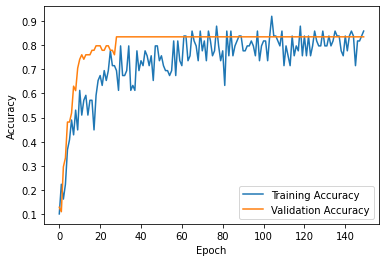

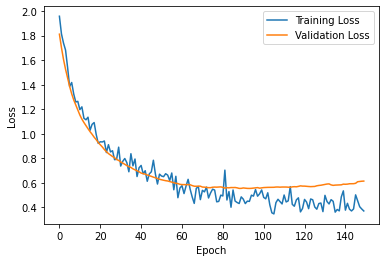

Best validation accuracy: 0.8333333134651184
Training accuracy at the best test accuracy: 0.6938775777816772
Best validation accuracy: 0.8333333134651184
Closest training accuracy to the maximum validation accuracy: 0.6938775777816772
Confusion matrix:
[[11  0  1  0  0  0]
 [ 1  1  0  0  0  2]
 [ 0  0  3  0  0  0]
 [ 0  0  0 16  0  1]
 [ 0  0  0  0  8  0]
 [ 0  0  0  3  1  6]]
Total Accuracy: 83.33333333333334
Total Precision: 0.8440545808966862
Total Recall: 0.7846405228758169
TP for each label [11  1  3 16  8  6]
Total data for each label [12  4  3 17  8 10]
FP for each label [1 0 1 3 1 3]
FN for each label [1 3 0 1 0 4]
Accuracy for each label: [ 91.66666667 100.          75.          84.21052632  88.88888889
  66.66666667]
Precision for each label: [0.91666667 1.         0.75       0.84210526 0.88888889 0.66666667]
Recall for each label: [0.91666667 0.25       1.         0.94117647 1.         0.6       ]


In [14]:
run_model(ratio_1, callback_1, log_dir1)

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
13       Pasar        1930.920185   Strategis   Sedang  14060
28       Pasar         251.818587   Strategis    Bagus   5785
57       Pasar        1031.829535   Strategis   Sedang   2252
43       Pasar        1676.146577   Strategis   Sedang   3840
29       Pasar        1730.459693   Strategis   Sedang   5784
32       Pasar        2406.214384   Strategis   Sedang   5200
41       Pasar        1839.107811   Strategis   Sedang   3987
11       Pasar         765.887686   Strategis    Bagus  15710
69       Pasar        3310.271455   Strategis   Sedang   1490
64       Pasar        1703.886238   Strategis   Sedang   1735
0        Pasar        2592.305034   Strategis   Sedang  87580
17   Perumahan        1294.590510   Strategis   Sedang   8985
5    Perumahan        2535.506573      Sedang   Sedang  27024
10   Perumahan        4519.160513      Kurang   Sedang  16590
1    Perumahan        2289.806804      Sedang   Sedang  87580
21      

/tmp/ipykernel_98662/2639660339.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Visibilitas = np.select(condition,value)
/tmp/ipykernel_98662/2639660339.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Bangunan = np.select(condition,value,0)
/tmp/ipykernel_98662/2639660339.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Epoch 1/150
60/60 [==============================] - 1s 6ms/step - loss: 1.7819 - accuracy: 0.2833 - val_loss: 1.5499 - val_accuracy: 0.3953
Epoch 2/150
60/60 [==============================] - 0s 3ms/step - loss: 1.6354 - accuracy: 0.3500 - val_loss: 1.4401 - val_accuracy: 0.3953
Epoch 3/150
60/60 [==============================] - 0s 4ms/step - loss: 1.5053 - accuracy: 0.3500 - val_loss: 1.3581 - val_accuracy: 0.4651
Epoch 4/150
60/60 [==============================] - 0s 4ms/step - loss: 1.5223 - accuracy: 0.4500 - val_loss: 1.2860 - val_accuracy: 0.5814
Epoch 5/150
60/60 [==============================] - 0s 4ms/step - loss: 1.3834 - accuracy: 0.4667 - val_loss: 1.2270 - val_accuracy: 0.6047
Epoch 6/150
60/60 [==============================] - 0s 3ms/step - loss: 1.3828 - accuracy: 0.5000 - val_loss: 1.1708 - val_accuracy: 0.6047
Epoch 7/150
60/60 [==============================] - 0s 3ms/step - loss: 1.3779 - accuracy: 0.5167 - val_loss: 1.1231 - val_accuracy: 0.6047
Epoch 8/150
6

Epoch 59/150
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6833 - val_loss: 0.4894 - val_accuracy: 0.8372
Epoch 60/150
60/60 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.7333 - val_loss: 0.4868 - val_accuracy: 0.8372
Epoch 61/150
60/60 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.7833 - val_loss: 0.4849 - val_accuracy: 0.8372
Epoch 62/150
60/60 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.8167 - val_loss: 0.4734 - val_accuracy: 0.8372
Epoch 63/150
60/60 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.7833 - val_loss: 0.4704 - val_accuracy: 0.8372
Epoch 64/150
60/60 [==============================] - 0s 3ms/step - loss: 0.5229 - accuracy: 0.7667 - val_loss: 0.4713 - val_accuracy: 0.8372
Epoch 65/150
60/60 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.7333 - val_loss: 0.4697 - val_accuracy: 0.8372
Epoch 

60/60 [==============================] - 0s 3ms/step - loss: 0.4420 - accuracy: 0.8167 - val_loss: 0.4217 - val_accuracy: 0.8605
Epoch 117/150
60/60 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.8000 - val_loss: 0.4223 - val_accuracy: 0.8605
Epoch 118/150
60/60 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.8000 - val_loss: 0.4229 - val_accuracy: 0.8605
Epoch 119/150
60/60 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.8333 - val_loss: 0.4229 - val_accuracy: 0.8605
Epoch 120/150
60/60 [==============================] - 0s 3ms/step - loss: 0.4866 - accuracy: 0.8333 - val_loss: 0.4272 - val_accuracy: 0.8605
Epoch 121/150
60/60 [==============================] - 0s 3ms/step - loss: 0.3856 - accuracy: 0.8667 - val_loss: 0.4272 - val_accuracy: 0.8605
Epoch 122/150
60/60 [==============================] - 0s 3ms/step - loss: 0.5658 - accuracy: 0.6833 - val_loss: 0.4271 - val_accuracy: 0.8605
Epoch 123/150

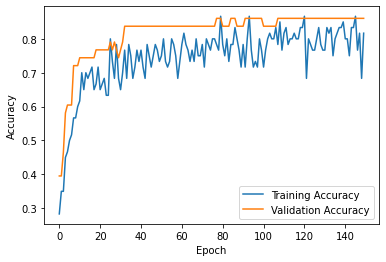

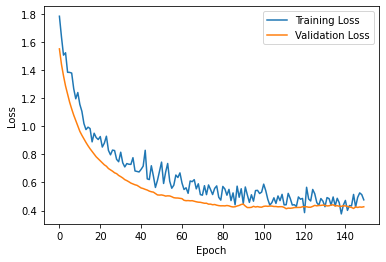

Best validation accuracy: 0.8604651093482971
Training accuracy at the best test accuracy: 0.7833333611488342
Best validation accuracy: 0.8604651093482971
Closest training accuracy to the maximum validation accuracy: 0.7833333611488342
Confusion matrix:
[[ 9  0  1  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  2  0  0  0]
 [ 0  0  0 14  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  3  0  5]]
Total Accuracy: 86.04651162790698
Total Precision: 0.8796296296296297
Total Recall: 0.8097222222222222
TP for each label [ 9  1  2 14  6  5]
Total data for each label [10  3  2 14  6  8]
FP for each label [0 0 1 4 0 1]
FN for each label [1 2 0 0 0 3]
Accuracy for each label: [100.         100.          66.66666667  77.77777778 100.
  83.33333333]
Precision for each label: [1.         1.         0.66666667 0.77777778 1.         0.83333333]
Recall for each label: [0.9        0.33333333 1.         1.         1.         0.625     ]


In [15]:
run_model(ratio_2, callback_2,log_dir2)

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
77       Pasar        3601.357402   Strategis   Sedang    905
39       Pasar        1838.230938   Strategis   Sedang   4105
13       Pasar        1930.920185   Strategis   Sedang  14060
28       Pasar         251.818587   Strategis    Bagus   5785
57       Pasar        1031.829535   Strategis   Sedang   2252
..         ...                ...         ...      ...    ...
74        Ruko        1656.318389   Strategis   Sedang   1150
100       Ruko       90078.934395      Sedang   Sedang     90
82        Ruko        2995.770020      Sedang   Sedang    599
71        Ruko         633.031834   Strategis    Bagus   1320
27        Ruko        1630.361226   Strategis    Bagus   5872

[69 rows x 5 columns]
   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
3       Pasar        1736.810427   Strategis   Sedang  55157
16      Pasar        2293.001800   Strategis   Sedang   9460
76      Pasar        1277.917889   Strategis   Sed

/tmp/ipykernel_98662/2639660339.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Peruntukan = np.select(condition,value,0)


Epoch 1/150
69/69 [==============================] - 1s 6ms/step - loss: 1.8701 - accuracy: 0.1449 - val_loss: 1.7303 - val_accuracy: 0.2353
Epoch 2/150
69/69 [==============================] - 0s 4ms/step - loss: 1.7912 - accuracy: 0.3188 - val_loss: 1.6250 - val_accuracy: 0.5588
Epoch 3/150
69/69 [==============================] - 0s 3ms/step - loss: 1.6201 - accuracy: 0.3333 - val_loss: 1.5340 - val_accuracy: 0.5882
Epoch 4/150
69/69 [==============================] - 0s 3ms/step - loss: 1.5495 - accuracy: 0.4348 - val_loss: 1.4442 - val_accuracy: 0.5882
Epoch 5/150
69/69 [==============================] - 0s 4ms/step - loss: 1.5139 - accuracy: 0.4783 - val_loss: 1.3579 - val_accuracy: 0.6471
Epoch 6/150
69/69 [==============================] - 0s 3ms/step - loss: 1.4201 - accuracy: 0.5217 - val_loss: 1.2807 - val_accuracy: 0.7941
Epoch 7/150
69/69 [==============================] - 0s 3ms/step - loss: 1.3353 - accuracy: 0.5072 - val_loss: 1.2138 - val_accuracy: 0.7941
Epoch 8/150
6

Epoch 59/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5270 - accuracy: 0.7826 - val_loss: 0.4037 - val_accuracy: 0.8824
Epoch 60/150
69/69 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.8261 - val_loss: 0.4012 - val_accuracy: 0.8824
Epoch 61/150
69/69 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.7971 - val_loss: 0.4009 - val_accuracy: 0.8824
Epoch 62/150
69/69 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.6957 - val_loss: 0.3959 - val_accuracy: 0.8824
Epoch 63/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5304 - accuracy: 0.8116 - val_loss: 0.3957 - val_accuracy: 0.8824
Epoch 64/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5262 - accuracy: 0.7391 - val_loss: 0.3953 - val_accuracy: 0.8824
Epoch 65/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.7971 - val_loss: 0.3916 - val_accuracy: 0.8824
Epoch 

69/69 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.8261 - val_loss: 0.3716 - val_accuracy: 0.8824
Epoch 117/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5262 - accuracy: 0.7826 - val_loss: 0.3694 - val_accuracy: 0.8824
Epoch 118/150
69/69 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.8261 - val_loss: 0.3694 - val_accuracy: 0.8824
Epoch 119/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.7536 - val_loss: 0.3645 - val_accuracy: 0.8824
Epoch 120/150
69/69 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.7971 - val_loss: 0.3665 - val_accuracy: 0.8824
Epoch 121/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5636 - accuracy: 0.7536 - val_loss: 0.3701 - val_accuracy: 0.8824
Epoch 122/150
69/69 [==============================] - 0s 3ms/step - loss: 0.4170 - accuracy: 0.8116 - val_loss: 0.3689 - val_accuracy: 0.8824
Epoch 123/150

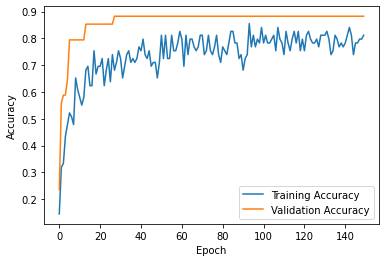

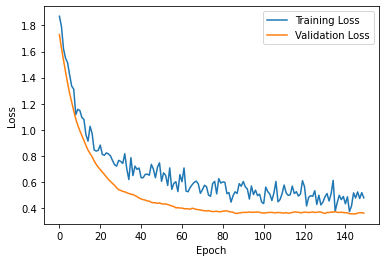

Best validation accuracy: 0.8823529481887817
Training accuracy at the best test accuracy: 0.6811594367027283
Best validation accuracy: 0.8823529481887817
Closest training accuracy to the maximum validation accuracy: 0.6811594367027283
Confusion matrix:
[[ 7  0  0  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  2  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  0  0  0  5  0]
 [ 0  0  0  2  0  4]]
Total Accuracy: 88.23529411764706
Total Precision: 0.9309523809523809
Total Recall: 0.8333333333333334
TP for each label [ 7  1  2 11  5  4]
Total data for each label [ 7  3  2 11  5  6]
FP for each label [0 0 0 3 0 1]
FN for each label [0 2 0 0 0 2]
Accuracy for each label: [100.         100.         100.          78.57142857 100.
  80.        ]
Precision for each label: [1.         1.         1.         0.78571429 1.         0.8       ]
Recall for each label: [1.         0.33333333 1.         1.         1.         0.66666667]


In [16]:
run_model(ratio_3, callback_3,log_dir3)

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
12       Pasar        1548.339050   Strategis   Sedang  14610
70       Pasar        1530.595895   Strategis   Sedang   1380
77       Pasar        3601.357402   Strategis   Sedang    905
39       Pasar        1838.230938   Strategis   Sedang   4105
13       Pasar        1930.920185   Strategis   Sedang  14060
..         ...                ...         ...      ...    ...
74        Ruko        1656.318389   Strategis   Sedang   1150
100       Ruko       90078.934395      Sedang   Sedang     90
82        Ruko        2995.770020      Sedang   Sedang    599
71        Ruko         633.031834   Strategis    Bagus   1320
27        Ruko        1630.361226   Strategis    Bagus   5872

[81 rows x 5 columns]
   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
3       Pasar        1736.810427   Strategis   Sedang  55157
16      Pasar        2293.001800   Strategis   Sedang   9460
76      Pasar        1277.917889   Strategis   Sed

81/81 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.7284 - val_loss: 0.3129 - val_accuracy: 0.9091
Epoch 44/150
81/81 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.7531 - val_loss: 0.3143 - val_accuracy: 0.9091
Epoch 45/150
81/81 [==============================] - 0s 2ms/step - loss: 0.5959 - accuracy: 0.7778 - val_loss: 0.3078 - val_accuracy: 0.9091
Epoch 46/150
81/81 [==============================] - 0s 3ms/step - loss: 0.5117 - accuracy: 0.7901 - val_loss: 0.3081 - val_accuracy: 0.9091
Epoch 47/150
81/81 [==============================] - 0s 3ms/step - loss: 0.5913 - accuracy: 0.7531 - val_loss: 0.3041 - val_accuracy: 0.9091
Epoch 48/150
81/81 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.7407 - val_loss: 0.2957 - val_accuracy: 0.9091
Epoch 49/150
81/81 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.7407 - val_loss: 0.2896 - val_accuracy: 0.9091
Epoch 50/150
81/81 

Epoch 101/150
81/81 [==============================] - 0s 3ms/step - loss: 0.5102 - accuracy: 0.8272 - val_loss: 0.2500 - val_accuracy: 0.9091
Epoch 102/150
81/81 [==============================] - 0s 3ms/step - loss: 0.4836 - accuracy: 0.7901 - val_loss: 0.2464 - val_accuracy: 0.9091
Epoch 103/150
81/81 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8272 - val_loss: 0.2435 - val_accuracy: 0.9091
Epoch 104/150
81/81 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.7901 - val_loss: 0.2430 - val_accuracy: 0.9091
Epoch 105/150
81/81 [==============================] - 0s 3ms/step - loss: 0.4172 - accuracy: 0.8395 - val_loss: 0.2425 - val_accuracy: 0.9091
Epoch 106/150
81/81 [==============================] - 0s 2ms/step - loss: 0.5039 - accuracy: 0.7778 - val_loss: 0.2325 - val_accuracy: 0.9091
Epoch 107/150
81/81 [==============================] - 0s 3ms/step - loss: 0.4283 - accuracy: 0.7778 - val_loss: 0.2361 - val_accuracy: 0.9091

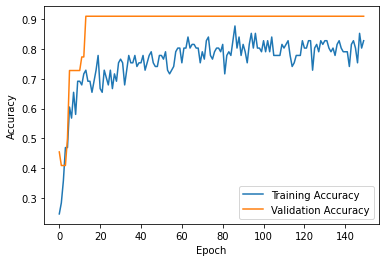

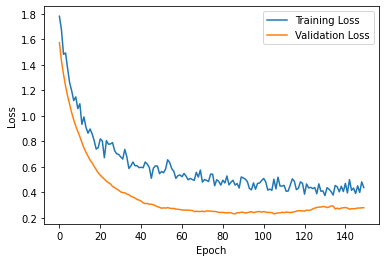

Best validation accuracy: 0.9090909361839294
Training accuracy at the best test accuracy: 0.7283950448036194
Best validation accuracy: 0.9090909361839294
Closest training accuracy to the maximum validation accuracy: 0.7283950448036194
Confusion matrix:
[[5 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 0 3 0]
 [0 0 0 1 0 3]]
Total Accuracy: 90.9090909090909
Total Precision: 0.9629629629629629
Total Recall: 0.875
TP for each label [5 1 1 7 3 3]
Total data for each label [5 2 1 7 3 4]
FP for each label [0 0 0 2 0 0]
FN for each label [0 1 0 0 0 1]
Accuracy for each label: [100.         100.         100.          77.77777778 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.77777778 1.         1.        ]
Recall for each label: [1.   0.5  1.   1.   1.   0.75]


In [17]:
run_model(ratio_4, callback_4, log_dir4)

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
76       Pasar        1277.917889   Strategis   Sedang    947
18       Pasar        2500.530108   Strategis   Sedang   8740
12       Pasar        1548.339050   Strategis   Sedang  14610
70       Pasar        1530.595895   Strategis   Sedang   1380
77       Pasar        3601.357402   Strategis   Sedang    905
..         ...                ...         ...      ...    ...
74        Ruko        1656.318389   Strategis   Sedang   1150
100       Ruko       90078.934395      Sedang   Sedang     90
82        Ruko        2995.770020      Sedang   Sedang    599
71        Ruko         633.031834   Strategis    Bagus   1320
27        Ruko        1630.361226   Strategis    Bagus   5872

[90 rows x 5 columns]
   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
3       Pasar        1736.810427   Strategis   Sedang  55157
16      Pasar        2293.001800   Strategis   Sedang   9460
35  Perumahan        2465.973567      Kurang   Sed

/tmp/ipykernel_98662/2639660339.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Peruntukan = np.select(condition,value,0)


Epoch 1/150
90/90 [==============================] - 1s 4ms/step - loss: 2.1078 - accuracy: 0.0889 - val_loss: 1.7708 - val_accuracy: 0.2308
Epoch 2/150
90/90 [==============================] - 0s 3ms/step - loss: 1.8239 - accuracy: 0.2444 - val_loss: 1.5837 - val_accuracy: 0.6154
Epoch 3/150
90/90 [==============================] - 0s 2ms/step - loss: 1.6625 - accuracy: 0.4111 - val_loss: 1.4451 - val_accuracy: 0.6154
Epoch 4/150
90/90 [==============================] - 0s 2ms/step - loss: 1.4932 - accuracy: 0.4778 - val_loss: 1.3151 - val_accuracy: 0.6154
Epoch 5/150
90/90 [==============================] - 0s 2ms/step - loss: 1.4487 - accuracy: 0.4667 - val_loss: 1.2175 - val_accuracy: 0.7692
Epoch 6/150
90/90 [==============================] - 0s 2ms/step - loss: 1.2638 - accuracy: 0.5444 - val_loss: 1.1357 - val_accuracy: 0.8462
Epoch 7/150
90/90 [==============================] - 0s 2ms/step - loss: 1.1932 - accuracy: 0.5778 - val_loss: 1.0528 - val_accuracy: 0.8462
Epoch 8/150
9

Epoch 59/150
90/90 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.8000 - val_loss: 0.4131 - val_accuracy: 0.9231
Epoch 60/150
90/90 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.7111 - val_loss: 0.4110 - val_accuracy: 0.9231
Epoch 61/150
90/90 [==============================] - 0s 2ms/step - loss: 0.5092 - accuracy: 0.8222 - val_loss: 0.4174 - val_accuracy: 0.9231
Epoch 62/150
90/90 [==============================] - 0s 2ms/step - loss: 0.5388 - accuracy: 0.7556 - val_loss: 0.4338 - val_accuracy: 0.9231
Epoch 63/150
90/90 [==============================] - 0s 2ms/step - loss: 0.5516 - accuracy: 0.7667 - val_loss: 0.4383 - val_accuracy: 0.9231
Epoch 64/150
90/90 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.8111 - val_loss: 0.4417 - val_accuracy: 0.9231
Epoch 65/150
90/90 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.7556 - val_loss: 0.4323 - val_accuracy: 0.9231
Epoch 

90/90 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.7889 - val_loss: 0.6153 - val_accuracy: 0.9231
Epoch 117/150
90/90 [==============================] - 0s 2ms/step - loss: 0.3907 - accuracy: 0.8444 - val_loss: 0.6234 - val_accuracy: 0.9231
Epoch 118/150
90/90 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.8111 - val_loss: 0.6276 - val_accuracy: 0.9231
Epoch 119/150
90/90 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.7889 - val_loss: 0.6088 - val_accuracy: 0.9231
Epoch 120/150
90/90 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7889 - val_loss: 0.6141 - val_accuracy: 0.9231
Epoch 121/150
90/90 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8444 - val_loss: 0.6419 - val_accuracy: 0.9231
Epoch 122/150
90/90 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.7667 - val_loss: 0.6482 - val_accuracy: 0.9231
Epoch 123/150

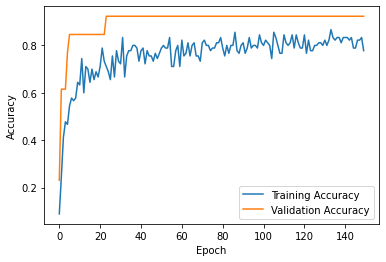

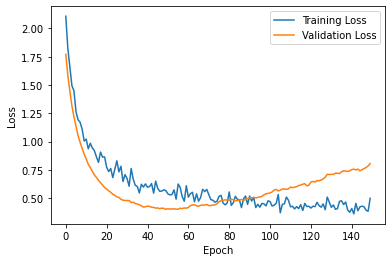

Best validation accuracy: 0.9230769276618958
Training accuracy at the best test accuracy: 0.7111111283302307
Best validation accuracy: 0.9230769276618958
Closest training accuracy to the maximum validation accuracy: 0.7111111283302307
Confusion matrix:
[[3 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]
Total Accuracy: 92.3076923076923
Total Precision: nan
Total Recall: 0.8333333333333334
TP for each label [3 0 1 4 2 2]
Total data for each label [3 1 1 4 2 2]
FP for each label [0 0 0 1 0 0]
FN for each label [0 1 0 0 0 0]
Accuracy for each label: [100.  nan 100.  80. 100. 100.]
Precision for each label: [1.  nan 1.  0.8 1.  1. ]
Recall for each label: [1. 0. 1. 1. 1. 1.]


/tmp/ipykernel_98662/2608161719.py:41: RuntimeWarning: invalid value encountered in divide
  class_accuracies = true_positives / class_data_totals * 100
/tmp/ipykernel_98662/2608161719.py:58: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)


In [18]:
run_model(ratio_5, callback_5,log_dir5)

# 

# Print the method

In [19]:
training, test_2 = get_data_with_ratio(0.5)
training.head()

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
57       Pasar        1031.829535   Strategis   Sedang   2252
43       Pasar        1676.146577   Strategis   Sedang   3840
29       Pasar        1730.459693   Strategis   Sedang   5784
32       Pasar        2406.214384   Strategis   Sedang   5200
41       Pasar        1839.107811   Strategis   Sedang   3987
11       Pasar         765.887686   Strategis    Bagus  15710
69       Pasar        3310.271455   Strategis   Sedang   1490
64       Pasar        1703.886238   Strategis   Sedang   1735
0        Pasar        2592.305034   Strategis   Sedang  87580
5    Perumahan        2535.506573      Sedang   Sedang  27024
10   Perumahan        4519.160513      Kurang   Sedang  16590
1    Perumahan        2289.806804      Sedang   Sedang  87580
31       Sawah        5402.735138      Kurang   Kosong   5700
22       Sawah        2766.267155      Kurang   Kosong   6635
23       Sawah        4216.298352      Kurang   Kosong   6390
25      

/tmp/ipykernel_98662/93346669.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_98662/93346669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)


,Peruntukan,Jarak_pusat_kota2,Visibilitas,Bangunan,Luas
57,Pasar,1031.829535,Strategis,Sedang,2252
43,Pasar,1676.146577,Strategis,Sedang,3840
29,Pasar,1730.459693,Strategis,Sedang,5784
32,Pasar,2406.214384,Strategis,Sedang,5200
41,Pasar,1839.107811,Strategis,Sedang,3987


In [20]:
test_2.head()

,Peruntukan,Jarak_pusat_kota2,Visibilitas,Bangunan,Luas
3,Pasar,1736.810427,Strategis,Sedang,55157
16,Pasar,2293.001800,Strategis,Sedang,9460
76,Pasar,1277.917889,Strategis,Sedang,947
18,Pasar,2500.530108,Strategis,Sedang,8740
12,Pasar,1548.339050,Strategis,Sedang,14610


In [21]:
#split data

    
    #change data to number
training = change_categorical_to_number(training)
test = change_categorical_to_number(test_2)

training.head()

/tmp/ipykernel_98662/2639660339.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Visibilitas = np.select(condition,value)
/tmp/ipykernel_98662/2639660339.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Bangunan = np.select(condition,value,0)
/tmp/ipykernel_98662/2639660339.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,Peruntukan,Jarak_pusat_kota2,Visibilitas,Bangunan,Luas
57,5,1031.829535,3,1,2252
43,5,1676.146577,3,1,3840
29,5,1730.459693,3,1,5784
32,5,2406.214384,3,1,5200
41,5,1839.107811,3,1,3987


In [22]:
test_2.head()

,Peruntukan,Jarak_pusat_kota2,Visibilitas,Bangunan,Luas
3,5,1736.810427,3,1,55157
16,5,2293.001800,3,1,9460
76,5,1277.917889,3,1,947
18,5,2500.530108,3,1,8740
12,5,1548.339050,3,1,14610


In [23]:

train_ds = df_to_dataset(training)
val_ds = df_to_dataset(test)
    
    #encoded features
dataset = train_ds  # Your dataset here

# Create an iterator for the dataset
iterator = dataset.make_one_shot_iterator()

# Get the next element from the iterator
next_element = iterator.get_next()

# Create a TensorFlow session
with tf.Session() as sess:
    try:
        while True:
            # Fetch and print the next element from the dataset
            element = sess.run(next_element)
            print(element)
    except tf.errors.OutOfRangeError:
        # This exception will be raised when all elements have been iterated through
        pass

AttributeError: 'BatchDataset' object has no attribute 'make_one_shot_iterator'

In [ ]:
dataset = train_ds  # Your dataset here

# Create an iterator for the dataset
iterator = dataset.make_one_shot_iterator()

# Get the next element from the iterator
next_element = iterator.get_next()

# Create a TensorFlow session
with tf.Session() as sess:
    try:
        while True:
            # Fetch and print the next element from the dataset
            element = sess.run(next_element)
            print(element)
    except tf.errors.OutOfRangeError:
        # This exception will be raised when all elements have been iterated through
        pass

In [ ]:
encoded,inputs = encoded_features(train_ds)

    


In [ ]:
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])


In [ ]:
y_true